In [1]:
import sympy as sp
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from math import sqrt
import time
from sympy.utilities.lambdify import lambdify
import random

epsilon = 1e-6
X, Y = sp.symbols('x y')

## Код методов

### Построение линий уровня и пути

In [2]:
def plot_levels(Q_def, lx=-5, rx=5, ly=-5, ry=5, gridsize=50, levels=(50), path=None):
    plt.figure()
    a = np.linspace(lx, rx, gridsize)
    b = np.linspace(ly, ry, gridsize)
    _x, _y = np.meshgrid(a, b)
    c = plt.contour(_x, _y, Q_def([_x, _y]), levels)
    if path != None:
        c = plt.plot(path[0], path[1], linewidth = 3, c='r')
        c = plt.scatter(path[0], path[1], s=10, c='purple')
    plt.grid()
    plt.show(c)

In [3]:
def get_x_and_err(path, wiki_x, wiki_y):
    err = []
    for i in range(len(path[0])):
        vec = np.array([path[0][i] - wiki_x, path[1][i] - wiki_y])
        err.append(np.linalg.norm(vec))
    x = [i for i in range(len(path[0]))]
    return x, err

In [4]:
def plot_err_step_all(path_GradientDescent,
                  path_Newton,
                  path_NewtonRaphson,
                  path_DFP,
                  path_BFGH,
                  path_FletcherReeves,
                  path_NelderMead,
                  path_HookeJeeves,
                  wiki_x, wiki_y):
    
    x_GradientDescent, err_GradientDescent = get_x_and_err(path_GradientDescent, wiki_x, wiki_y)
    x_Newton, err_Newton = get_x_and_err(path_Newton, wiki_x, wiki_y)
    x_NewtonRaphson, err_NewtonRaphson = get_x_and_err(path_NewtonRaphson, wiki_x, wiki_y)
    x_DFP, err_DFP = get_x_and_err(path_DFP, wiki_x, wiki_y)
    x_BFGH, err_BFGH = get_x_and_err(path_BFGH, wiki_x, wiki_y)
    x_FletcherReeves, err_FletcherReeves = get_x_and_err(path_FletcherReeves, wiki_x, wiki_y)
    x_NelderMead, err_NelderMead = get_x_and_err(path_NelderMead, wiki_x, wiki_y)
    x_HookeJeeves, err_HookeJeeves = get_x_and_err(path_HookeJeeves, wiki_x, wiki_y)
    
    fig = plt.plot(x_GradientDescent, err_GradientDescent, label='err_GradientDescent')
    fig = plt.plot(x_Newton, err_Newton, label='err_Newton')
    fig = plt.plot(x_NewtonRaphson, err_NewtonRaphson, label='err_NewtonRaphson')
    fig = plt.plot(x_DFP, err_DFP, label='err_DFP')
    fig = plt.plot(x_BFGH, err_BFGH, label='err_BFGH')
    fig = plt.plot(x_FletcherReeves, err_FletcherReeves, label='err_FletcherReeves')
    fig = plt.plot(x_NelderMead, err_NelderMead, label='err_NelderMead')
    fig = plt.plot(x_HookeJeeves, err_HookeJeeves, label='err_HookeJeeves')
    fig = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.plot(ax, err)
    plt.show()

In [5]:
def plot_err_step(path, wiki_x, wiki_y):
    x, y = get_x_and_err(path, wiki_x, wiki_y)
    fig = plt.plot(x, y)
    plt.show()

### Вычисление значения функции

In [6]:
def Q_value(Q, _x, _y):
    return Q.evalf(subs={x:_x, y:_y})

### Вычисление (анти)градиента

In [7]:
def antigrad(Q_def, x, eps):
    # approx_fprime вычисляет градиент в точке с заданной точностью
    return -1 * optimize.approx_fprime(x, Q_def, eps**2)

def Gradient(function, dot):
    gradient_x = float(function.diff(X).subs({X: dot[0], Y: dot[1]}))
    gradient_y = float(function.diff(Y).subs({X: dot[0], Y: dot[1]}))
    return np.array([gradient_x, gradient_y])


### Вычисление гессиана

In [8]:
def hessian(Q, x_value: float, y_value: float):
  x, y = sp.symbols('x y')
  res = [[lambdify((x, y), sp.hessian(Q, (x, y))[0], 'numpy')(x_value, y_value), lambdify((x, y),
          sp.hessian(Q, (x, y))[1], 'numpy')(x_value, y_value)],
      [lambdify((x, y), sp.hessian(Q, (x, y))[2], 'numpy')(x_value, y_value), 
       lambdify((x, y), sp.hessian(Q, (x, y))[3], 'numpy')(x_value, y_value)]]
  return np.array(res)

### Проверка отрицательности гессиана

In [9]:
def is_hessian_negative(hessian):
  if (hessian[0][0] < 0):
    return True
  elif hessian[0][0] * hessian[1][1] - hessian[1][0] * hessian[0][1] < 0:
    return True
  return False

### Разложение Холесского

In [10]:
def holesskiy(hessian, delta=0.1, returnld=False):
  g = hessian
  n = len(hessian)
  d = [[0 for i in range(n)] for _ in range(n)]
  d[0][0] = g[0][0]
  l = [[0 for _ in range(n)] for _ in range(n)]
  for i in range(n):
    l[i][i] = 1
  for i in range(1, n):
    l[0][i] = (1 / d[0][0]) * g[0][i]
  for i in range(1, n):
    sum_ = 0
    for s in range(0, i):
        sum_ += l[s][i] ** 2 * d[s][s]
    d[i][i] = g[i][i] - sum_
    sum_ = 0
    for j in range(i + 1, n):
        for s in range(0, n):
            sum_ += l[s][i] * l[s][j] * d[s][s]
        l[i][j] = (g[i][j] - sum_) / d[i][i]
  for i in range(len(d)):
    if (d[i][i] < 0):
        d[i][i] = delta
  l = np.array(l)
  l_t = np.transpose(l)
  d = np.array(d)
  res = np.matmul(l_t, d)
  res = np.matmul(res, l)
  if returnld:
        return l, d
  return np.array(res)

def holessky(A):
    D = np.zeros((2, 2))
    L = np.zeros((2, 2))
    L[0][0] = 1
    L[1][1] = 1
    D[0][0] = A[0][0]
    L[1][0] = A[1][0] / D[0][0]
    D[1][1] = A[1][1] - D[0][0] * L[1][0]**2
    res = np.matmul(np.matmul(L, D), L.transpose())
    
    cnt_true = 0
    cnt_true += abs(A[0][0] - res[0][0]) < epsilon
    cnt_true += abs(A[1][0] - res[1][0]) < epsilon
    cnt_true += abs(A[0][1] - res[0][1]) < epsilon
    cnt_true += abs(A[1][1] - res[1][1]) < epsilon
    assert cnt_true == 4
    return (L, D)

### Класс вектора (для недлера-мида)

In [11]:
class Vector(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return "({0:.9f}, {1:.9f})".format(self.x, self.y)

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Vector(x, y)

    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return Vector(x, y)

    def __rmul__(self, other):
        x = self.x * other
        y = self.y * other
        return Vector(x, y)

    def __truediv__(self, other):
        x = self.x / other
        y = self.y / other
        return Vector(x, y)

    def distance(a, b):
      return ((a.x - b.x)**2 + (a.y - b.y)**2)**0.5

    def points(self):
        return (self.x, self.y)

### Градиентный спуск

In [12]:
def GradientDescent(Q_def, max_iter_count, start_x=0, start_y=0, eps=1e-4):
    t0 = time.time()
    path_x = [start_x]
    path_y = [start_y]
    current_point = np.array([start_x, start_y], dtype=np.float64)
        
    iter_counter = 0
    
    # dk - направление смещения
    dk = antigrad(Q_def, current_point, eps)

    while np.linalg.norm(dk) > eps and iter_counter < max_iter_count:
        iter_counter += 1
        dk = antigrad(Q_def, current_point, eps)
        # xk - величина смещения -
        # - точка минимума заданной функции в направлении антиградиента (функция как от одного аргумента)
        Q_of_the_xk = lambda _xk: Q_def(*[current_point+_xk*dk])
        xk = optimize.minimize_scalar(Q_of_the_xk).x
        current_point += xk*dk
        path_x.append(current_point[0])
        path_y.append(current_point[1])
    
    print(f'Time: {time.time()-t0} seconds')
    return current_point, (path_x, path_y), iter_counter

### Метод Ньютона (классический)

In [13]:
def Newton(Q_sp, Q_def, max_iter, start_x=0, start_y=0, eps=1e-4):
  t0 = time.time()
  curr = np.array([start_x, start_y], dtype=np.float64)
  _x = [start_x]
  _y = [start_y]
  iter = 0
  hess = hessian(Q_sp, start_x, start_y)
  dk = np.linalg.inv(hess).dot(antigrad(Q_def, curr, eps))
  while np.linalg.norm(dk) > eps and iter < max_iter:
    iter += 1
    dk = np.linalg.inv(hess).dot(antigrad(Q_def, curr, eps))
    curr = curr + dk
    hess = hessian(Q_sp, curr[0], curr[1])
    _x.append(curr[0])
    _y.append(curr[1])

  print(f'Time: {time.time()-t0} seconds')
  return curr, (_x, _y), iter 

### Метод Ньютона-Рафсона с регулировкой шага и модификацией гессиана

In [14]:
def NewtonRaphson(Q_sp, Q_def, max_iter, start_x=0, start_y=0, eps=1e-4):
  t0 = time.time()
  _x = [start_x]
  _y = [start_y]
  curr = np.array([start_x, start_y], dtype=np.float64)
  iter = 0
  hess = hessian(Q_sp, curr[0], curr[1])
  if is_hessian_negative(hess):
      hess = holesskiy(hess)
      print('Negative hessian')
  dk = np.linalg.inv(hess).dot(antigrad(Q_def, curr, eps))
  while np.linalg.norm(dk) > eps and iter < max_iter:
      iter += 1
      if is_hessian_negative(hess):
        hess = holesskiy(hess)
        print('Negative hessian')
      dk = np.linalg.inv(hess).dot(antigrad(Q_def, curr, eps))
      Q_of_the_xk = lambda _xk: Q_def(*[curr+_xk*dk])
      xk = optimize.minimize_scalar(Q_of_the_xk).x
      curr += xk*dk
      _x.append(curr[0])
      _y.append(curr[1])
  print(f'Time: {time.time()-t0} seconds')
  return curr, (_x, _y), iter

### Что-то для квази

In [15]:
def SLE(A, b):
    
    x = np.matmul(np.linalg.inv(A), b)
    res = np.matmul(A, x)
    
    cnt_true = 0
    cnt_true += abs(b[0] - res[0]) < epsilon
    cnt_true += abs(b[1] - res[1]) < epsilon
    assert cnt_true == 2
    return x

def CalcValue(function, dot):
    return float(function.subs({X: dot[0], Y: dot[1]}))

### Казиньютоновский DFP

In [16]:
def DFP(function, maxiteration, start_x=0, start_y=0, eps=1e-4):
    t0 = time.time()
    initial_dot = (start_x, start_y)
    dots = []
    curr_dot = initial_dot
    g_cur = np.array([[1, 0], [0, 1]], dtype=np.float32)
    while len(dots) < maxiteration:
        dots.append(curr_dot)
        L, D = holessky(g_cur)
        anti_gradient = -Gradient(function, curr_dot)
        if D[0][0] <= 0 or D[1][1] <= 0:
            d_k = anti_gradient
        else:
            v = SLE(L, anti_gradient.reshape(-1, 1))
            d_k = SLE(np.matmul(D, L.transpose()), v).ravel()
        
        l_min = optimize.minimize_scalar(lambda l: CalcValue(function, curr_dot + d_k * l)).x
        nxt_dot = curr_dot + d_k * l_min
        
        next_anti_gradient = -Gradient(function, nxt_dot)
        if np.linalg.norm(next_anti_gradient) < eps:
            dots.append(nxt_dot)
            break
        nxt_f = CalcValue(function, nxt_dot)
        nxt_grad = -next_anti_gradient
        nabula = (nxt_dot - curr_dot).reshape(-1, 1)
        cur_z = (nxt_grad + anti_gradient).reshape(-1, 1)
        first_slog = np.matmul(np.matmul(np.matmul(g_cur, nabula), nabula.transpose()), g_cur) / np.matmul(np.matmul(nabula.transpose(), g_cur), nabula)[0][0]
        if abs(np.matmul(cur_z.transpose(), nabula)[0][0]) < 1e-20:
            print('CAN NOT CONVERGE')
            return -1, -1, -1
        second_slog = np.matmul(cur_z, cur_z.transpose()) / np.matmul(cur_z.transpose(), nabula)[0][0]
        w = cur_z / np.matmul(cur_z.transpose(), nabula)[0][0] - np.matmul(g_cur, nabula) / np.matmul(np.matmul(nabula.transpose(), g_cur), nabula)[0][0]
        chislo = np.matmul(np.matmul(nabula.transpose(), g_cur), nabula)[0][0]
        third_slog = np.matmul(w, w.transpose()) * chislo

        g_nxt = g_cur - first_slog + second_slog + third_slog
        g_cur = g_nxt
        curr_dot = nxt_dot
    print(f'Time: {time.time()-t0} seconds')
    path_x = []
    path_y = []
    for d in dots:
        path_x.append(d[0])
        path_y.append(d[1])
    
    return dots[len(dots)-1], (path_x, path_y), len(dots)
    

### Казиньютоновский BFGH

In [17]:
def BFGH(function, maxiteration, start_x=0, start_y=0, eps=1e-4):
    t0 = time.time()
    initial_dot = (start_x, start_y)
    dots = []
    curr_dot = initial_dot
    g_cur = np.array([[1, 0], [0, 1]], dtype=np.float32)
    while len(dots) < maxiteration:
        dots.append(curr_dot)
        L, D = holessky(g_cur)
        anti_gradient = -Gradient(function, curr_dot)
        if D[0][0] <= 0 or D[1][1] <= 0:
            d_k = anti_gradient
        else:
            v = SLE(L, anti_gradient.reshape(-1, 1))
            d_k = SLE(np.matmul(D, L.transpose()), v).ravel()
        
        l_min = optimize.minimize_scalar(lambda l: CalcValue(function, curr_dot + d_k * l)).x
        nxt_dot = curr_dot + d_k * l_min
        
        next_anti_gradient = -Gradient(function, nxt_dot)
        if np.linalg.norm(next_anti_gradient) < eps:
            dots.append(nxt_dot)
            break
        nxt_f = CalcValue(function, nxt_dot)
        nxt_grad = -next_anti_gradient
        nabula = (nxt_dot - curr_dot).reshape(-1, 1)
        cur_z = (nxt_grad + anti_gradient).reshape(-1, 1)
        first_slog = np.matmul(np.matmul(np.matmul(g_cur, nabula), nabula.transpose()), g_cur) / np.matmul(np.matmul(nabula.transpose(), g_cur), nabula)[0][0]
        if abs(np.matmul(cur_z.transpose(), nabula)[0][0]) < 1e-20:
            print('CAN NOT CONVERGE')
            return -1, -1, -1
        second_slog = np.matmul(cur_z, cur_z.transpose()) / np.matmul(cur_z.transpose(), nabula)[0][0]

        g_nxt = g_cur - first_slog + second_slog
        g_cur = g_nxt
        curr_dot = nxt_dot
    print(f'Time: {time.time()-t0} seconds')
    path_x = []
    path_y = []
    for d in dots:
        path_x.append(d[0])
        path_y.append(d[1])
    
    return dots[len(dots)-1], (path_x, path_y), len(dots)

### Метод Флетчера Ривсса

In [18]:
def FletcherReeves(fsympy, f, max_iter, x_start, y_start, e=1e-4):
    t0 = time.time()
    x1 = sp.symbols('x')
    x2 = sp.symbols('y')
    y = sp.symbols('y')
    x0 = (x_start, y_start)
    PathX = []
    PathY = []
    #H = hess(f)
    xcur = np.array(x0) # step 0
    
    gradS = [sp.diff(fsympy, x1), sp.diff(fsympy, x2)]
    gradN = lambdify((x1, x2), gradS, 'numpy')
    grad = np.array(gradN(xcur[0], xcur[1])) # step 1

    PathX.append(xcur[0])
    PathY.append(xcur[1])
    n = len(x0)
    k = 0 # step1

    prevgrad = 1
   
    #grad = optimize.approx_fprime(xcur, f, e**4)
    pk = -1*grad # step 1
    while np.linalg.norm(grad) > e**2 and k < max_iter: # step 4
        if (k%n==0):  # step 5
            pk = -1*grad
        #if (grad.dot(pk) >= 0):
        #    pk = -1*grad
        else:
            bk = (pow(np.linalg.norm(grad), 2))/(pow(np.linalg.norm(prevgrad),2)) # step 6
            prevpk = pk
            pk = -1*grad + bk*prevpk # step 6

        q = lambda xk: f(*[xcur+xk*pk])
        a = optimize.minimize_scalar(q).x
        
        xcur = xcur + a*pk # step 3
        PathX.append(xcur[0])
        PathY.append(xcur[1])
        k=k+1
        prevgrad=grad

        grad = np.array(gradN(xcur[0], xcur[1])) # step 3
        #grad = optimize.approx_fprime(xcur, f, e**4)
    print(f'Time: {time.time()-t0} seconds')
    return xcur, (PathX, PathY), k

### Метод Нелдера-Мида

In [19]:
def NelderMead(func, maxiter, x_start, y_start, offset, a=1, b=1.5, c=0.5, d=0.5, epsilony=0.000000001, epsilonf=0.000000001):
    t0 = time.time()
    V = []
    iteration = 0
    iteration_array = []
    error_array = []
    vectors = []
    vectors.append(Vector(x_start, y_start))
    vectors.append(Vector(x_start, y_start+offset))
    vectors.append(Vector(x_start+offset, y_start+offset))
#     for i in range(3):
#         vectors.append(Vector(random.uniform(-1.5, 1.5), random.uniform(-1.5, 1.5)))
    iteration = 0

    v1 = vectors[0]
    v2 = vectors[1]
    v3 = vectors[2]

    for i in range(maxiter):
        iteration += 1
        adict = {v1:func(v1.points()), v2:func(v2.points()), v3:func(v3.points())}
        points = sorted(adict.items(), key=lambda x: x[1])
        
        #step 2
        best = points[0][0]
        good = points[1][0]
        worst = points[2][0]

        #step 3
        mid = (good + best)/2 

        #step 4 - check breakpoints
        yc = (worst + good + best) / 3
        fc = (func(worst.points()) + func(good.points()) + func(best.points())) / 3

        lambday = ((Vector.distance(worst, yc))**2 + Vector.distance(good, yc)**2 + Vector.distance(best, yc)**2)**0.5 / 3
        lambdaf = ((func(worst.points()) - fc)**2 + (func(good.points()) - fc)**2 + (func(best.points()) - fc)**2)**0.5 / 3
        error_array.append(lambdaf)
        iteration_array.append(iteration)

        if lambday < epsilony and lambdaf < epsilonf:
            print(f'Time: {time.time()-t0} seconds')  
            path_x = []
            path_y = []
            for i in range(len(V)):
                path_x.append(V[i].x)
                path_y.append(V[i].y)
            return best, (path_x, path_y), iteration

        #step 5 - reflection
        ys = mid + a * (mid - worst)
        fys = func(ys.points())
        
        #step 6 - expansion
        if func(ys.points()) <= func(good.points()):
            yss = mid + b * (ys - mid)
            if func(yss.points()) <= func(ys.points()):
              worst = yss
            else:
              worst = ys
        #step 7
        else:
            if func(best.points()) < fys and fys < func(good.points()) or func(best.points()) < fys and fys < func(worst.points()):
              worst = ys
            else:
              #step 8 - shrinking
              if fys < func(worst.points()):
                ysss = mid + c * (worst - mid)
              #shrinking to best vertex
              else:
                good = best + d * (good - best)
                worst = best + d * (worst - best)
        # update points
        v1 = worst
        v2 = good
        v3 = best
        V.append(best)

    print(f'Time: {time.time()-t0} seconds')
    path_x = []
    path_y = []
    for i in range(len(V)):
        path_x.append(V[i].x)
        path_y.append(V[i].y)
    return best, (path_x, path_y), iteration

### Метод Хука-Дживса

In [20]:
def build_config(zx, zy, h, Q):
    N = 2
    e = [(1, 0), (0, 1)]
    new_zx = zx
    new_zy = zy
    for i in range(0, N):
        tmpx = new_zx + h * e[i][0]
        tmpy = new_zy + h * e[i][1]
        if Q_value(Q, tmpx, tmpy) < Q_value(Q, new_zx, new_zy):
            new_zx = tmpx
            new_zy = tmpy
        else:
            tmpx = new_zx - h * e[i][0]
            tmpy = new_zy - h * e[i][1]
            if Q_value(Q, tmpx, tmpy) < Q_value(Q, new_zx, new_zy):
                new_zx = tmpx
                new_zy = tmpy
    return (new_zx, new_zy)

In [21]:
def HookeJeeves(Q, maxiter, x0, y0, h=1e-2, eps=1e-5):
    t0 = time.time()
    all_x = [] ##
    all_y = [] ##
    Y = [(None, None)]*(maxiter+2)
    Y[0] = (x0, y0)
    Z = [(None, None)]*(maxiter+2)
    iter_counter = 0
    # step 0
    alpha = 2
    
    while iter_counter < maxiter:
        # step 1
        Z[1] = Y[0]
        all_x.append(Z[1][0]) ##
        all_y.append(Z[1][1]) ##
        k = 0
        while iter_counter < maxiter:
            iter_counter += 1
            # step 2
            cfg = build_config(Z[k+1][0], Z[k+1][1], h, Q)
            Y[k+1] = cfg
            all_x.append(cfg[0])
            all_y.append(cfg[1])
            # step 3
            if Q_value(Q, Y[k+1][0], Y[k+1][1]) < Q_value(Q, Y[k][0], Y[k][1]):
                k = k + 1
                tmp = (Y[k][0] + alpha*(Y[k][0] - Y[k-1][0]), Y[k][1] + alpha*(Y[k][1] - Y[k-1][1]))
                Z[k+1] = tmp
                all_x.append(tmp[0]) ##
                all_y.append(tmp[1]) ##
                continue # goto step 2
            else:
                if h <= eps:
                    print(f'Time: {time.time()-t0} seconds')
                    return Y[k], (all_x, all_y), iter_counter # Y[k], Y, iter_counter
                else:
                    if k == 0:
                        h = h / 2
                    else:
                        Y[0] = Y[k]
                    break # goto step 1
    print(f'Time: {time.time()-t0} seconds')
    return Y[k], all_x, all_y, iter_counter# Y[k], Y, iter_counter

## Тестовые функции

### Rosenbrock

In [22]:
x = sp.symbols('x')
y = sp.symbols('y')

In [23]:
Rosenbrock = (1-x)**2 + 100*(y-x**2)**2

def rosenbrock_def(x):
  return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2

### Goldstein–Price

In [24]:
Goldstein = (1+((x+y+1)**2)*(19-14*x+3*x**2-14*y+6*x*y+3*y**2))*(30+((2*x-3*y)**2)*(18-32*x+12*x**2+48*y-36*x*y+27*y**2))

def goldstein_def(x):
  return (1+((x[0]+x[1]+1)**2)*(19-14*x[0]+3*x[0]**2-14*x[1]+6*x[0]*x[1]+3*x[1]**2))*(30+((2*x[0]-3*x[1])**2)*(18-32*x[0]+12*x[0]**2+48*x[1]-36*x[0]*x[1]+27*x[1]**2))

### Matyas

In [25]:
Matyas = 0.26*(x**2+y**2)-0.48*x*y

def matyas_def(x):
  return (0.26*(x[0]**2+x[1]**2)-0.48*x[0]*x[1])

### Himmelblau's

In [26]:
Himmel = (x**2+y-11)**2+(x+y**2-7)**2

In [27]:
def himmel_def(x):
  return (x[0]**2+x[1]-11)**2+(x[0]+x[1]**2-7)**2

## Тестирование

In [28]:
GlobalRes = ""

### Rosenbrock

In [29]:
Rosenbrock

(1 - x)**2 + 100*(-x**2 + y)**2

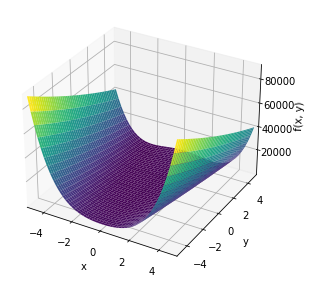

In [30]:
sp.plotting.plot3d(Rosenbrock, (x, -5, 5), (y, -5 , 5))

#### Градиентный спуск

In [31]:
res_point, path_GradientDescent, iter_count = GradientDescent(rosenbrock_def, 10000,  -1, -1)

Time: 1.2279276847839355 seconds


In [32]:
res_point

array([0.99999852, 0.99999703])

In [33]:
Q_value(Rosenbrock, res_point[0], res_point[1])

2.20100973010414e-12

In [34]:
iter_count

3839

In [35]:
GlobalRes += f"Rosenbrock GradientDescent, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Rosenbrock, res_point[0], res_point[1])}\n"

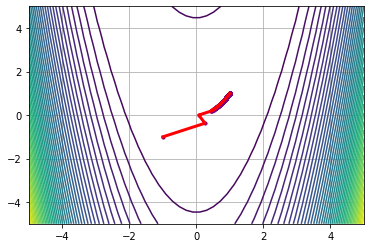

In [36]:
plot_levels(rosenbrock_def, path=path_GradientDescent)

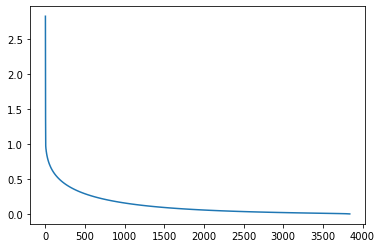

In [37]:
plot_err_step(path_GradientDescent, 1, 1)

#### Метод Ньютона

In [38]:
res_point, path_Newton, iter_count = Newton(Rosenbrock, rosenbrock_def, 10000, -1, -1)

Time: 0.05485343933105469 seconds


In [39]:
res_point

array([0.999997  , 0.99999399])

In [40]:
Q_value(Rosenbrock, res_point[0], res_point[1])

9.02960522331384e-12

In [41]:
iter_count

5

In [42]:
GlobalRes += f"Rosenbrock Newton, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Rosenbrock, res_point[0], res_point[1])}\n"

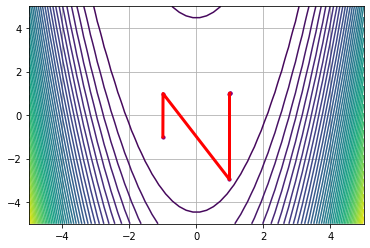

In [43]:
plot_levels(rosenbrock_def, path=path_Newton)

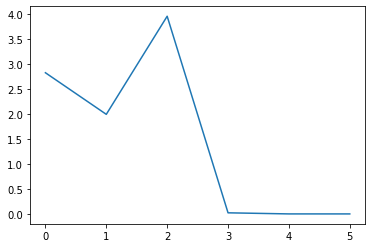

In [44]:
plot_err_step(path_Newton, 1, 1)

#### Метод Ньютона-Рафсона

In [45]:
res_point, path_NewtonRaphson, iter_count = NewtonRaphson(Rosenbrock, rosenbrock_def, 10000, -1, -1)

Time: 2.7474889755249023 seconds


In [46]:
res_point

array([0.96083167, 0.92319733])

In [47]:
Q_value(Rosenbrock, res_point[0], res_point[1])

0.00153415834906352

In [48]:
iter_count

7771

In [49]:
GlobalRes += f"Rosenbrock NewtonRaphson, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Rosenbrock, res_point[0], res_point[1])}\n"

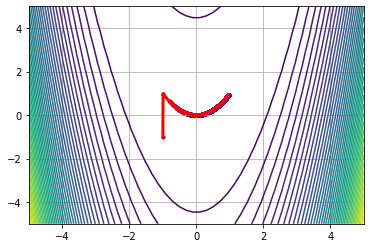

In [50]:
plot_levels(rosenbrock_def, path=path_NewtonRaphson)

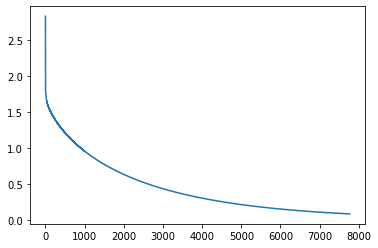

In [51]:
plot_err_step(path_NewtonRaphson, 1, 1)

#### Квазиньютоновский DFP

In [52]:
res_point, path_DFP,  iter_count = DFP(Rosenbrock, 10000, -1, -1)

Time: 0.46387791633605957 seconds


In [53]:
res_point

array([1.00000002, 1.00000002])

In [54]:
Q_value(Rosenbrock, res_point[0], res_point[1])

3.44724890946953e-15

In [55]:
iter_count

12

In [56]:
GlobalRes += f"Rosenbrock DFP, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Rosenbrock, res_point[0], res_point[1])}\n"

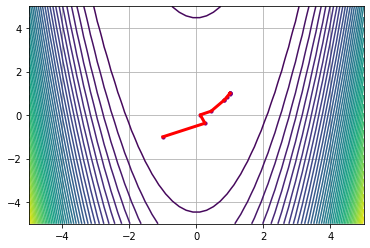

In [57]:
plot_levels(rosenbrock_def, path=path_DFP)

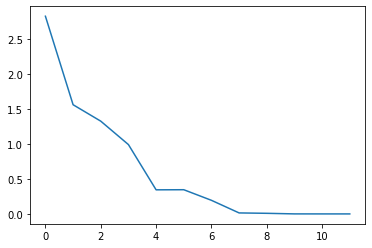

In [58]:
plot_err_step(path_DFP, 1, 1)

#### Квазиньютоновский BFGH

In [59]:
res_point, path_BFGH,  iter_count = BFGH(Rosenbrock, 10000, -1, -1)

Time: 0.4196467399597168 seconds


In [60]:
res_point

array([1.00000002, 1.00000002])

In [61]:
Q_value(Rosenbrock, res_point[0], res_point[1])

3.45426750538782e-15

In [62]:
iter_count

12

In [63]:
GlobalRes += f"Rosenbrock BFGH, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Rosenbrock, res_point[0], res_point[1])}\n"

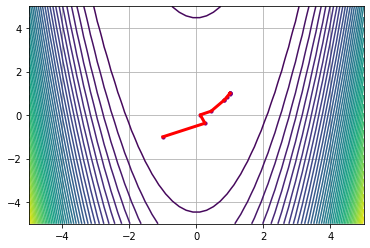

In [64]:
plot_levels(rosenbrock_def, path=path_BFGH)

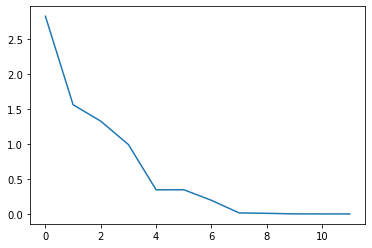

In [65]:
plot_err_step(path_BFGH, 1, 1)

#### Метод Флетчера-Ривса

In [66]:
res_point, path_FletcherReeves, iter_count = FletcherReeves(Rosenbrock, rosenbrock_def, 10000, -1, -1)

Time: 0.00797891616821289 seconds


In [67]:
res_point

array([1., 1.])

In [68]:
Q_value(Rosenbrock, res_point[0], res_point[1])

4.85762254982473e-21

In [69]:
iter_count

21

In [70]:
GlobalRes += f"Rosenbrock FletcherReeves, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Rosenbrock, res_point[0], res_point[1])}\n"

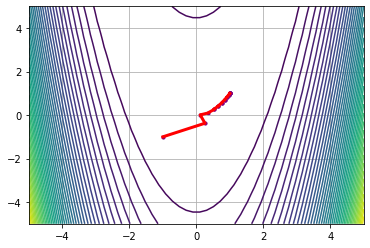

In [71]:
plot_levels(rosenbrock_def, path=path_FletcherReeves)

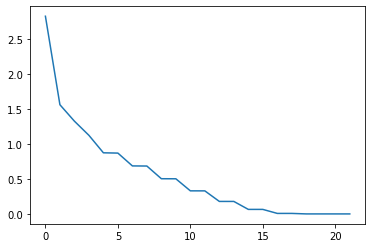

In [72]:
plot_err_step(path_FletcherReeves, 1, 1)

#### Метод Нелдера-Мида

In [73]:
res_point, path_NelderMead, iter_count = NelderMead(rosenbrock_def, 10000, -1, -1, offset = 0.3)

Time: 0.00202178955078125 seconds


In [74]:
res_point

(1.000000000, 1.000000000)

In [75]:
Q_value(Rosenbrock, res_point.x, res_point.y)

3.15598140273586e-19

In [76]:
iter_count

101

In [77]:
GlobalRes += f"Rosenbrock NelderMead, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Rosenbrock, res_point.x, res_point.y)}\n"

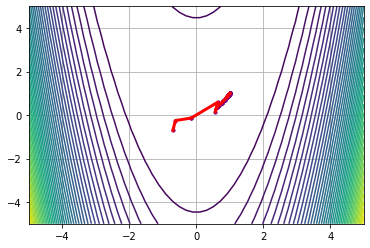

In [78]:
plot_levels(rosenbrock_def, path=path_NelderMead)

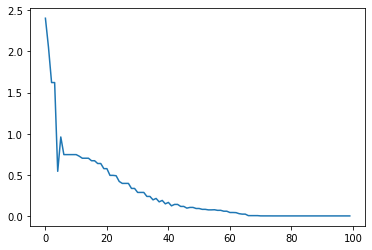

In [79]:
plot_err_step(path_NelderMead, 1, 1)

#### Метод Хука-Дживса

In [80]:
res_point, path_HookeJeeves, iter_count = HookeJeeves(Rosenbrock, 10000, -1, -1)

Time: 0.18067097663879395 seconds


In [81]:
res_point

(0.9985156250000038, 0.9970312500000085)

In [82]:
Q_value(Rosenbrock, res_point[0], res_point[1])

2.20385462417033e-6

In [83]:
iter_count

70

In [84]:
GlobalRes += f"Rosenbrock HookeJeeves, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Rosenbrock, res_point[0], res_point[1])}\n"

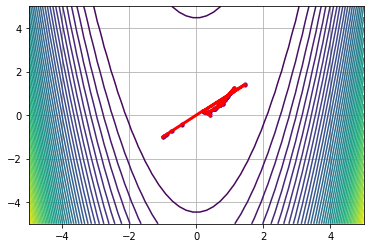

In [85]:
plot_levels(rosenbrock_def, path=path_HookeJeeves)

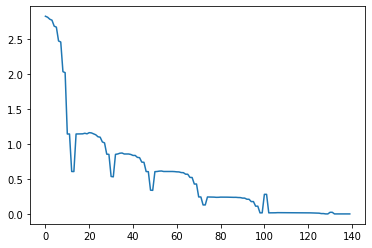

In [86]:
plot_err_step(path_HookeJeeves, 1, 1)

#### Все на одном

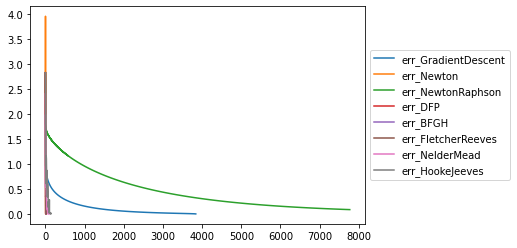

In [87]:
plot_err_step_all(path_GradientDescent,
              path_Newton,
              path_NewtonRaphson,
              path_DFP,
              path_BFGH,
              path_FletcherReeves,
              path_NelderMead,
              path_HookeJeeves,
              1, 1)

### Goldstein–Price

In [88]:
Goldstein

((2*x - 3*y)**2*(12*x**2 - 36*x*y - 32*x + 27*y**2 + 48*y + 18) + 30)*((x + y + 1)**2*(3*x**2 + 6*x*y - 14*x + 3*y**2 - 14*y + 19) + 1)

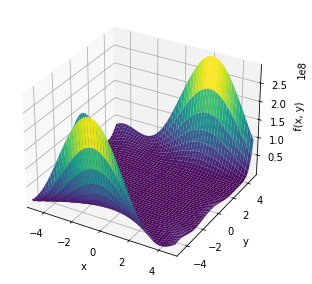

In [89]:
sp.plotting.plot3d(Goldstein, (x, -5, 5), (y, -5 , 5))

In [90]:
levels = [10*i for i in range(1, 10, 5)] + [100*i for i in range(1, 100, 10)] + [300*i for i in range(100, 10000, 100)]

#### Градиентный спуск

In [91]:
res_point, path_GradientDescent, iter_count = GradientDescent(goldstein_def, 10000,  -3, -2)

Time: 0.006981372833251953 seconds


In [92]:
res_point

array([-4.14419529e-08, -9.99999979e-01])

In [93]:
Q_value(Goldstein, res_point[0], res_point[1])

3.00000000000080

In [94]:
iter_count

11

In [95]:
GlobalRes += f"Goldstein GradientDescent, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Goldstein, res_point[0], res_point[1])}\n"

In [96]:
levels = [10*i for i in range(1, 10, 5)] + [100*i for i in range(1, 100, 10)] + [300*i for i in range(100, 10000, 100)]

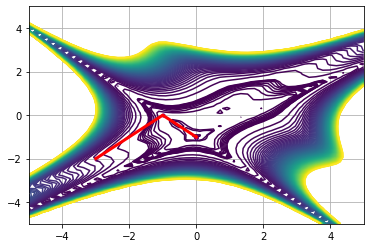

In [97]:
plot_levels(goldstein_def, levels=levels, path=path_GradientDescent)

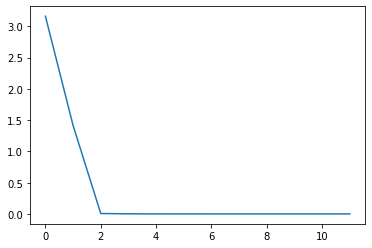

In [98]:
plot_err_step(path_GradientDescent, 0, -1)

#### Метод Ньютона

In [99]:
res_point, path_Newton, iter_count = Newton(Goldstein, goldstein_def, 10000, -3, -3)

Time: 0.7661323547363281 seconds


In [100]:
res_point

array([ 3.06826101e-09, -9.99999999e-01])

In [101]:
Q_value(Goldstein, res_point[0], res_point[1])

3.00000000000000

In [102]:
iter_count

8

In [103]:
GlobalRes += f"Goldstein Newton, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Goldstein, res_point[0], res_point[1])}\n"

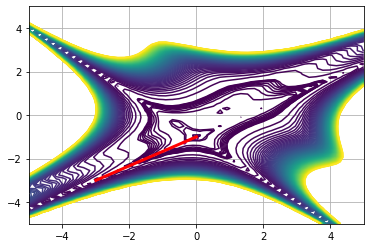

In [104]:
plot_levels(goldstein_def, levels=levels, path=path_Newton)

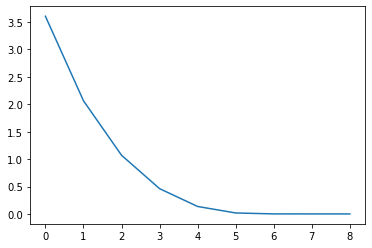

In [105]:
plot_err_step(path_Newton, 0, -1)

#### Метод Ньютона-Рафсона

In [106]:
res_point, path_NewtonRaphson, iter_count = NewtonRaphson(Goldstein, goldstein_def, 10000, -3, -3)

Time: 0.0778193473815918 seconds


In [107]:
res_point

array([ 5.2109061e-09, -1.0000000e+00])

In [108]:
Q_value(Goldstein, res_point[0], res_point[1])

3.00000000000002

In [109]:
iter_count

2

In [110]:
GlobalRes += f"Goldstein NewtonRaphson, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Goldstein, res_point[0], res_point[1])}\n"

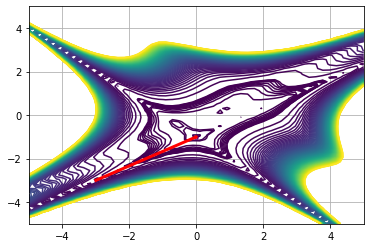

In [111]:
plot_levels(goldstein_def, levels=levels, path=path_NewtonRaphson)

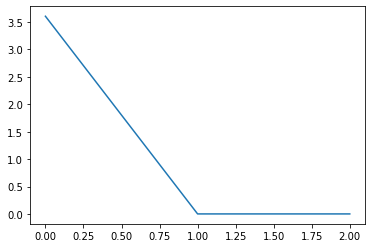

In [112]:
plot_err_step(path_NewtonRaphson, 0, -1)

#### Квазиньютоновский DFP

In [113]:
res_point, path_DFP,  iter_count = DFP(Goldstein, 10000, -3, -2)

Time: 1.4385013580322266 seconds


In [114]:
res_point

array([ 3.44053669e-08, -1.00000001e+00])

In [115]:
Q_value(Goldstein, res_point[0], res_point[1])

3.00000000000050

In [116]:
iter_count

6

In [117]:
GlobalRes += f"Goldstein DFP, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Goldstein, res_point[0], res_point[1])}\n"

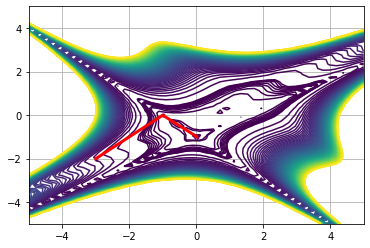

In [118]:
plot_levels(goldstein_def, levels=levels, path=path_DFP)

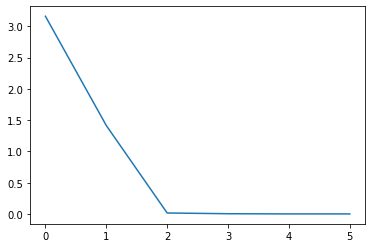

In [119]:
plot_err_step(path_DFP, 0, -1)

#### Квазиньютоновский BFGH

In [120]:
res_point, path_BFGH,  iter_count = BFGH(Goldstein, 10000, -3, -2)

Time: 1.5636885166168213 seconds


In [121]:
res_point

array([ 3.90481193e-08, -1.00000001e+00])

In [122]:
Q_value(Goldstein, res_point[0], res_point[1])

3.00000000000051

In [123]:
iter_count

6

In [124]:
GlobalRes += f"Goldstein BFGH, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Goldstein, res_point[0], res_point[1])}\n"

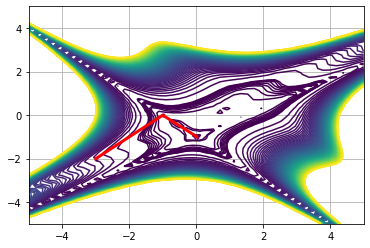

In [125]:
plot_levels(goldstein_def, levels=levels, path=path_BFGH)

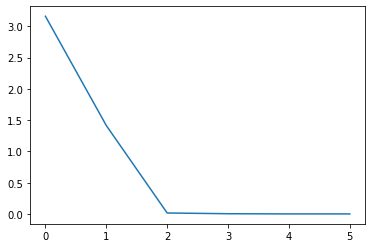

In [126]:
plot_err_step(path_BFGH, 0, -1)

#### Метод Флетчера-Ривса

In [127]:
res_point, path_FletcherReeves, iter_count = FletcherReeves(Goldstein, goldstein_def, 10000, -3, -2)

Time: 7.057404279708862 seconds


In [128]:
res_point

array([-3.71914337e-09, -1.00000000e+00])

In [129]:
Q_value(Goldstein, res_point[0], res_point[1])

3.00000000000000

In [130]:
iter_count

10000

In [131]:
GlobalRes += f"Goldstein FletcherReeves, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Goldstein, res_point[0], res_point[1])}\n"

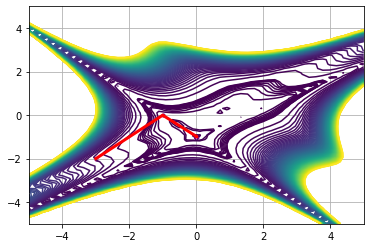

In [132]:
plot_levels(goldstein_def, levels=levels, path=path_FletcherReeves)

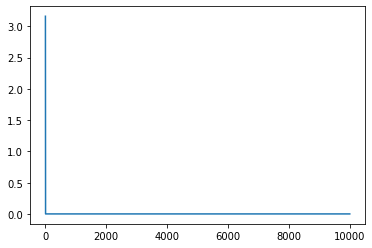

In [133]:
plot_err_step(path_FletcherReeves, 0, -1)

#### Метод Нелдера-Мида 

In [134]:
res_point, path_NelderMead, iter_count = NelderMead(goldstein_def, 10000, -3, -2, offset = 0.5)

Time: 0.001995563507080078 seconds


In [135]:
res_point

(-0.000000001, -1.000000000)

In [136]:
Q_value(Goldstein, res_point.x, res_point.y)

3.00000000000000

In [137]:
iter_count

48

In [138]:
GlobalRes += f"Goldstein NelderMead, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Goldstein, res_point.x, res_point.y)}\n"

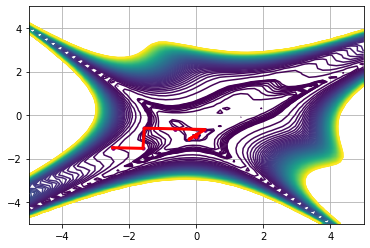

In [139]:
plot_levels(goldstein_def, levels=levels, path=path_NelderMead)

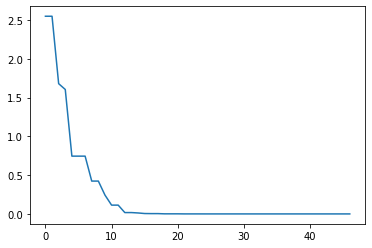

In [140]:
plot_err_step(path_NelderMead, 0, -1)

#### Метод Хука-Дживса

In [141]:
res_point, path_HookeJeeves, iter_count = HookeJeeves(Goldstein, 10000, -4, -4)

Time: 0.8211894035339355 seconds


In [142]:
res_point

(-1.0102162162350936e-13, -1.0000000000000755)

In [143]:
Q_value(Goldstein, res_point[0], res_point[1])

3.00000000000000

In [144]:
iter_count

47

In [145]:
GlobalRes += f"Goldstein HookeJeeves, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Goldstein, res_point[0], res_point[1])}\n"

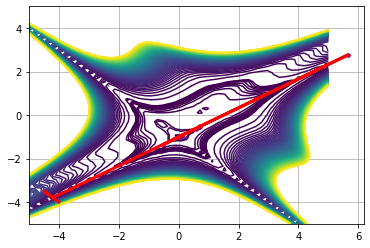

In [146]:
plot_levels(goldstein_def, levels=levels, path=path_HookeJeeves)

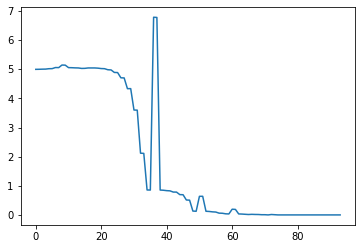

In [147]:
plot_err_step(path_HookeJeeves, 0, -1)

#### Все на одном

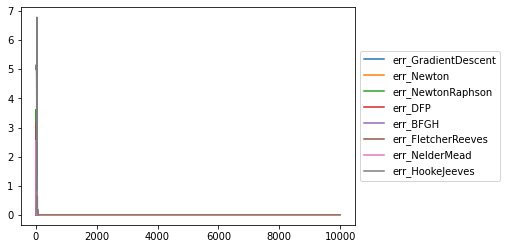

In [148]:
plot_err_step_all(path_GradientDescent,
              path_Newton,
              path_NewtonRaphson,
              path_DFP,
              path_BFGH,
              path_FletcherReeves,
              path_NelderMead,
              path_HookeJeeves,
              0, -1)

### Matyas

In [149]:
Matyas

0.26*x**2 - 0.48*x*y + 0.26*y**2

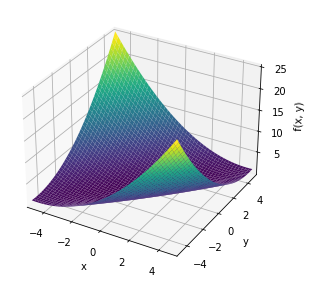

In [150]:
sp.plotting.plot3d(Matyas, (x, -5, 5), (y, -5 , 5))

#### Градиентный спуск

In [151]:
res_point, path_GradientDescent, iter_count = GradientDescent(matyas_def, 10000,  -4, -2)

Time: 0.0029916763305664062 seconds


In [152]:
res_point

array([-0.00020486, -0.00010243])

In [153]:
Q_value(Matyas, res_point[0], res_point[1])

3.56710228438655e-9

In [154]:
iter_count

14

In [155]:
GlobalRes += f"Matyas GradientDescent, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Matyas, res_point[0], res_point[1])}\n"

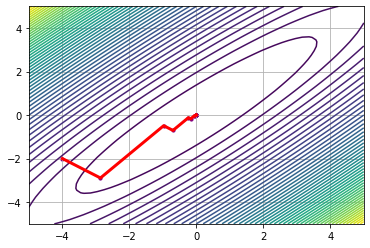

In [156]:
plot_levels(matyas_def, path=path_GradientDescent)

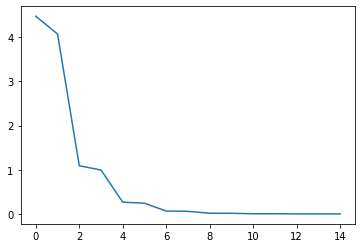

In [157]:
plot_err_step(path_GradientDescent, 0, 0)

#### Метод Ньютона

In [158]:
res_point, path_Newton, iter_count = Newton(Matyas, matyas_def, 10000, -4, -2)

Time: 0.022966623306274414 seconds


In [159]:
res_point

array([-6.5e-08, -6.5e-08])

In [160]:
Q_value(Matyas, res_point[0], res_point[1])

1.68999999999904e-16

In [161]:
iter_count

2

In [162]:
GlobalRes += f"Matyas Newton, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Matyas, res_point[0], res_point[1])}\n"

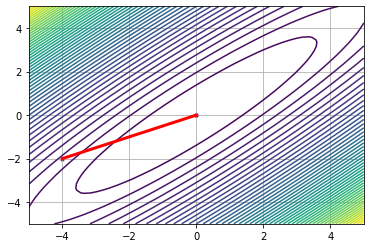

In [163]:
plot_levels(matyas_def, path=path_Newton)

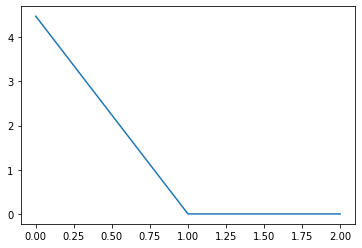

In [164]:
plot_err_step(path_Newton, 0, 0)

#### Метод Ньютона-Рафсона

In [165]:
res_point, path_NewtonRaphson, iter_count = NewtonRaphson(Matyas, matyas_def, 10000, -4, -2)

Time: 0.005193233489990234 seconds


In [166]:
res_point

array([-1.58360499e-08, -6.09872680e-09])

In [167]:
Q_value(Matyas, res_point[0], res_point[1])

2.85152097465584e-17

In [168]:
iter_count

2

In [169]:
GlobalRes += f"Matyas NewtonRaphson, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Matyas, res_point[0], res_point[1])}\n"

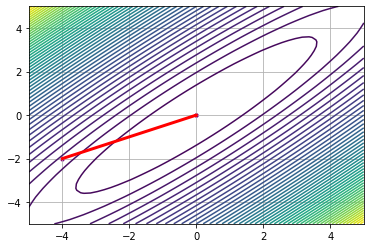

In [170]:
plot_levels(matyas_def, path=path_NewtonRaphson)

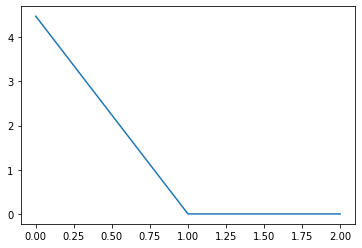

In [171]:
plot_err_step(path_NewtonRaphson, 0, 0)

#### Квазиньютоновский DFP

In [172]:
res_point, path_DFP,  iter_count = DFP(Matyas, 10000, -4, -2)

Time: 0.03191518783569336 seconds


In [173]:
res_point

array([ 4.03355401e-07, -3.16924615e-07])

In [174]:
Q_value(Matyas, res_point[0], res_point[1])

1.29775527877390e-13

In [175]:
iter_count

3

In [176]:
GlobalRes += f"Matyas DFP, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Matyas, res_point[0], res_point[1])}\n"

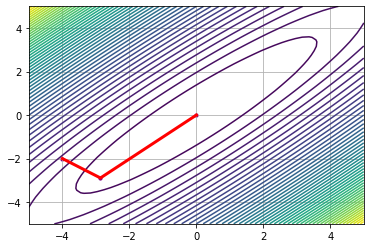

In [177]:
plot_levels(matyas_def, path=path_DFP)

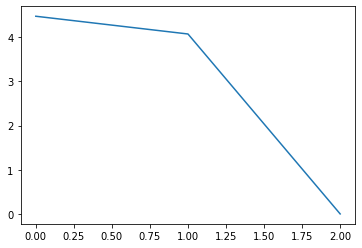

In [178]:
plot_err_step(path_DFP, 0, 0)

#### Квазиньютоновский BFGH

In [179]:
res_point, path_BFGH,  iter_count = BFGH(Matyas, 10000, -4, -2)

Time: 0.018949031829833984 seconds


In [180]:
res_point

array([ 3.97858334e-07, -3.12605881e-07])

In [181]:
Q_value(Matyas, res_point[0], res_point[1])

1.26262529853928e-13

In [182]:
iter_count

3

In [183]:
GlobalRes += f"Matyas BFGH, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Matyas, res_point[0], res_point[1])}\n"

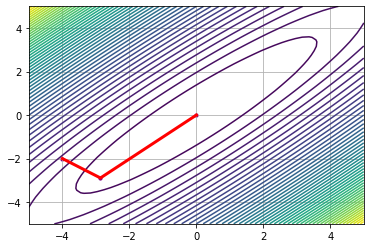

In [184]:
plot_levels(matyas_def, path=path_BFGH)

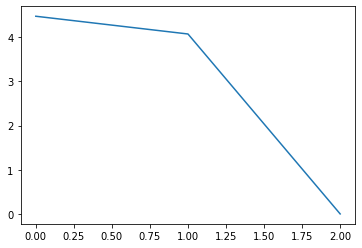

In [185]:
plot_err_step(path_BFGH, 0, 0)

#### Метод Флетчера-Ривса

In [186]:
res_point, path_FletcherReeves, iter_count = FletcherReeves(Matyas, matyas_def, 10000, -4, -2)

Time: 0.002992868423461914 seconds


In [187]:
res_point

array([-3.97748052e-08, -3.97900811e-08])

In [188]:
Q_value(Matyas, res_point[0], res_point[1])

6.33057696770741e-17

In [189]:
iter_count

3

In [190]:
GlobalRes += f"Matyas FletcherReeves, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Matyas, res_point[0], res_point[1])}\n"

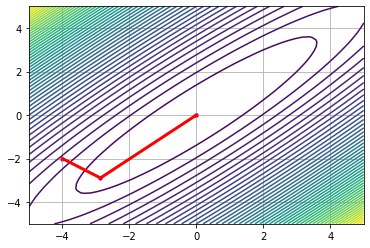

In [191]:
plot_levels(matyas_def, path=path_FletcherReeves)

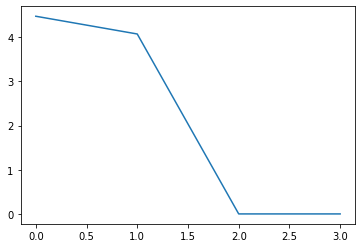

In [192]:
plot_err_step(path_FletcherReeves, 0, 0)

#### Метод Нелдера-Мида 

In [193]:
res_point, path_NelderMead, iter_count = NelderMead(matyas_def, 10000, -4, -2,  offset = 0.5)

Time: 0.0009970664978027344 seconds


In [194]:
res_point

(-0.000000001, -0.000000001)

In [195]:
Q_value(Matyas, res_point.x, res_point.y)

2.60561210070766e-20

In [196]:
iter_count

55

In [197]:
GlobalRes += f"Matyas NelderMead, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Matyas, res_point.x, res_point.y)}\n"

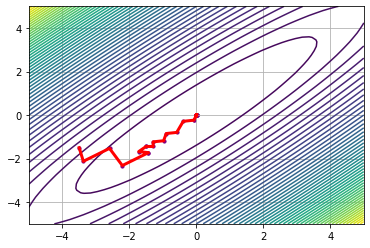

In [198]:
plot_levels(matyas_def, path=path_NelderMead)

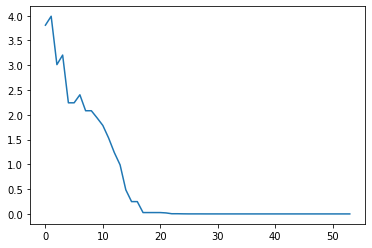

In [199]:
plot_err_step(path_NelderMead, 0, 0)

#### Метод Хука-Дживса

In [200]:
res_point, path_HookeJeeves, iter_count = HookeJeeves(Matyas, 10000, -4, -2)

Time: 0.08411026000976562 seconds


In [201]:
res_point

(1.953124992748161e-05, 1.9531249968337817e-05)

In [202]:
Q_value(Matyas, res_point[0], res_point[1])

1.52587889811089e-11

In [203]:
iter_count

56

In [204]:
GlobalRes += f"Matyas HookeJeeves, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Matyas, res_point[0], res_point[1])}\n"

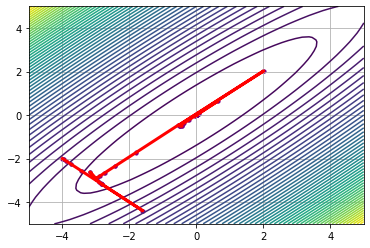

In [205]:
plot_levels(matyas_def, path=path_HookeJeeves)

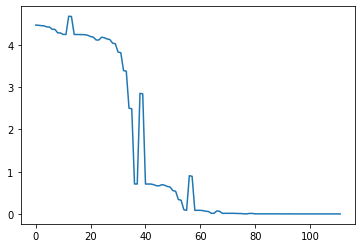

In [206]:
plot_err_step(path_HookeJeeves, 0, 0)

#### Все на одном

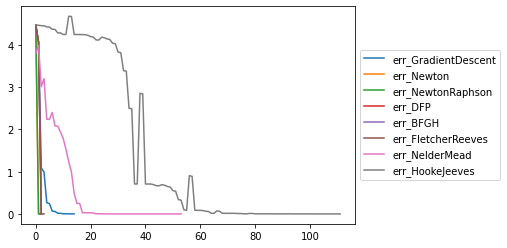

In [207]:
plot_err_step_all(path_GradientDescent,
              path_Newton,
              path_NewtonRaphson,
              path_DFP,
              path_BFGH,
              path_FletcherReeves,
              path_NelderMead,
              path_HookeJeeves,
              0, 0)

### Himmelblau's

In [208]:
Himmel

(x + y**2 - 7)**2 + (x**2 + y - 11)**2

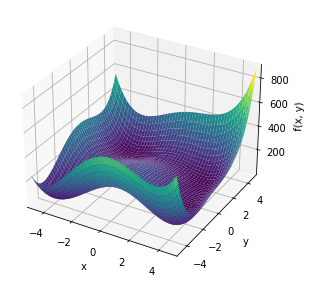

In [209]:
sp.plotting.plot3d(Himmel, (x, -5, 5), (y, -5 , 5))

#### Градиентный спуск

In [210]:
res_point, path_GradientDescent, iter_count = GradientDescent(himmel_def, 10000,  -4, -2)

Time: 0.0039882659912109375 seconds


In [211]:
res_point

array([-3.77931027, -3.28318597])

In [212]:
Q_value(Himmel, res_point[0], res_point[1])

3.78200989015198e-14

In [213]:
iter_count

10

In [214]:
GlobalRes += f"Himmel GradientDescent, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Himmel, res_point[0], res_point[1])}\n"

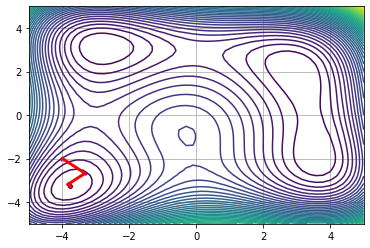

In [215]:
plot_levels(himmel_def, path=path_GradientDescent)

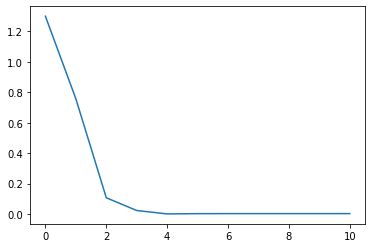

In [216]:
plot_err_step(path_GradientDescent, -3.78, -3.28)

#### Метод Ньютона

In [217]:
res_point, path_Newton, iter_count = Newton(Himmel, himmel_def, 10000, -4, -2)

Time: 0.0992281436920166 seconds


In [218]:
res_point

array([-3.77931026, -3.283186  ])

In [219]:
Q_value(Himmel, res_point[0], res_point[1])

3.53802631221079e-15

In [220]:
iter_count

11

In [221]:
GlobalRes += f"Himmel Newton, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Himmel, res_point[0], res_point[1])}\n"

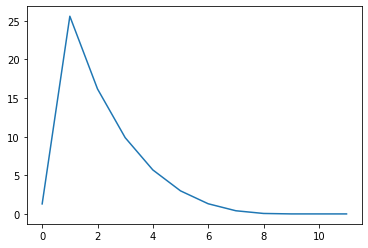

In [222]:
plot_err_step(path_Newton, -3.78, -3.28)

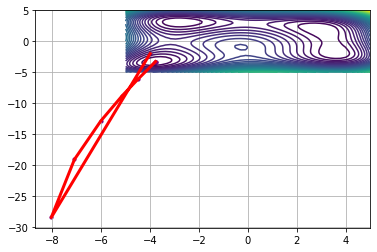

In [223]:
plot_levels(himmel_def, path=path_Newton)

#### Метод Ньютона-Рафсона

In [224]:
res_point, path_NewtonRaphson, iter_count = NewtonRaphson(Himmel, himmel_def, 10000, -4, -2)

Time: 0.02299022674560547 seconds


In [225]:
res_point

array([-2.80518133,  3.13136436])

In [226]:
Q_value(Himmel, res_point[0], res_point[1])

2.33721296805613e-7

In [227]:
iter_count

44

In [228]:
GlobalRes += f"Himmel NewtonRaphson, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Himmel, res_point[0], res_point[1])}\n"

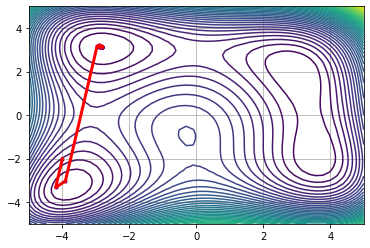

In [229]:
plot_levels(himmel_def, path=path_NewtonRaphson)

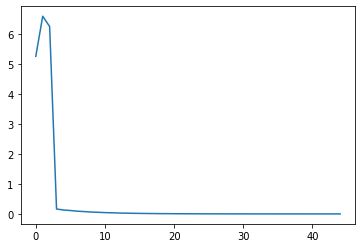

In [230]:
plot_err_step(path_NewtonRaphson, -2.80, 3.13)

#### Квазиньютоновский DFP

In [231]:
res_point, path_DFP,  iter_count = DFP(Himmel, 10000, -4, -2)

Time: 0.24440550804138184 seconds


In [232]:
res_point

array([-3.77931027, -3.28318604])

In [233]:
Q_value(Himmel, res_point[0], res_point[1])

8.17913565077859e-14

In [234]:
iter_count

6

In [235]:
GlobalRes += f"Himmel DFP, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Himmel, res_point[0], res_point[1])}\n"

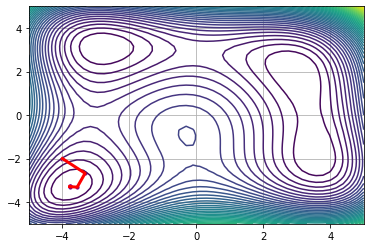

In [236]:
plot_levels(himmel_def, path=path_DFP)

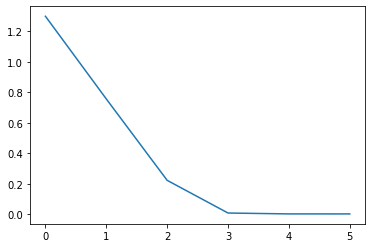

In [237]:
plot_err_step(path_DFP, -3.78, -3.28)

#### Квазиньютоновский BFGH

In [238]:
res_point, path_BFGH,  iter_count = BFGH(Himmel, 10000, -4, -2)

Time: 0.213456392288208 seconds


In [239]:
res_point

array([-3.77931027, -3.28318604])

In [240]:
Q_value(Himmel, res_point[0], res_point[1])

8.17919602011935e-14

In [241]:
iter_count

6

In [242]:
GlobalRes += f"Himmel BFGH, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Himmel, res_point[0], res_point[1])}\n"

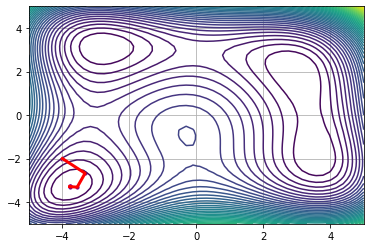

In [243]:
plot_levels(himmel_def, path=path_BFGH)

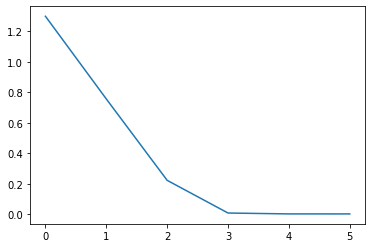

In [244]:
plot_err_step(path_BFGH, -3.78, -3.28)

#### Метод Флетчера-Ривса

In [245]:
res_point, path_FletcherReeves, iter_count = FletcherReeves(Himmel, himmel_def, 10000, -4, -2)

Time: 0.004987239837646484 seconds


In [246]:
res_point

array([-3.77931025, -3.28318599])

In [247]:
Q_value(Himmel, res_point[0], res_point[1])

4.63696793770510e-27

In [248]:
iter_count

8

In [249]:
GlobalRes += f"Himmel FletcherReeves, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Himmel, res_point[0], res_point[1])}\n"

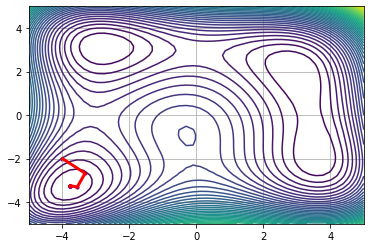

In [250]:
plot_levels(himmel_def, path=path_FletcherReeves)

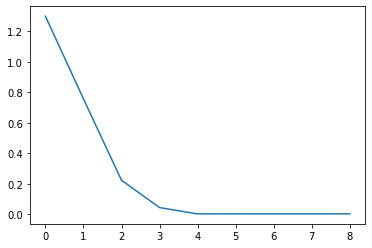

In [251]:
plot_err_step(path_FletcherReeves, -3.78, -3.28)

#### Метод Нелдера-Мида 

In [252]:
res_point, path_NelderMead, iter_count = NelderMead(himmel_def, 10000, -4, -2,  offset = 0.5)

Time: 0.000997781753540039 seconds


In [253]:
res_point

(-3.779310253, -3.283185991)

In [254]:
Q_value(Himmel, res_point.x, res_point.y)

2.12497461035952e-17

In [255]:
iter_count

47

In [256]:
GlobalRes += f"Himmel NelderMead, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Himmel, res_point.x, res_point.y)}\n"

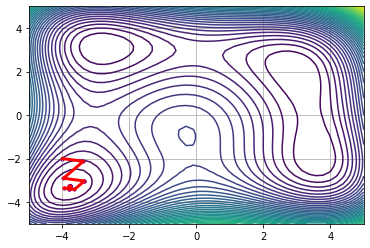

In [257]:
plot_levels(himmel_def, path=path_NelderMead)

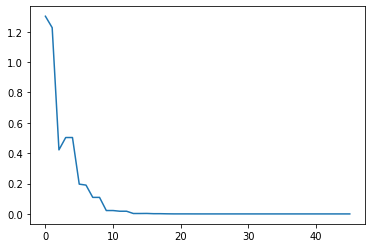

In [258]:
plot_err_step(path_NelderMead, res_point.x, res_point.y)

#### Метод Хука-Дживса

In [259]:
res_point, path_HookeJeeves, iter_count = HookeJeeves(Himmel, 10000, -4, -2)

Time: 0.07582950592041016 seconds


In [260]:
res_point

(-3.779306640625004, -3.2831835937499725)

In [261]:
Q_value(Himmel, res_point[0], res_point[1])

7.67647545082173e-10

In [262]:
iter_count

51

In [263]:
GlobalRes += f"Himmel HookeJeeves, iters: {iter_count}, point: {res_point}, qvalue: {Q_value(Himmel, res_point[0], res_point[1])}\n"

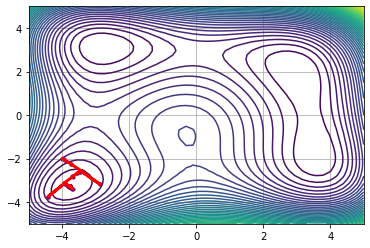

In [264]:
plot_levels(himmel_def, path=path_HookeJeeves)

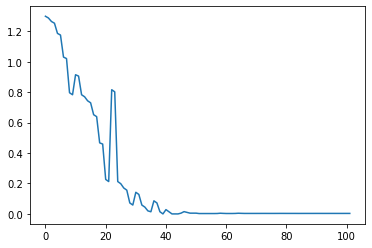

In [265]:
plot_err_step(path_HookeJeeves, -3.78, -3.28)

#### Все на одном

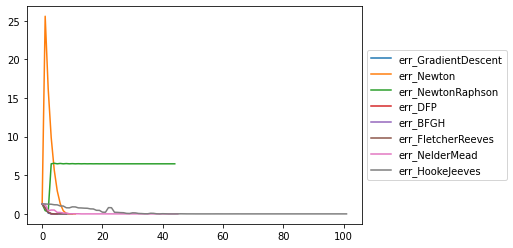

In [266]:
plot_err_step_all(path_GradientDescent,
              path_Newton,
              path_NewtonRaphson,
              path_DFP,
              path_BFGH,
              path_FletcherReeves,
              path_NelderMead,
              path_HookeJeeves,
              -3.78, -3.28)

In [268]:
print(GlobalRes)

Rosenbrock GradientDescent, iters: 3839, point: [0.99999852 0.99999703], qvalue: 2.20100973010414E-12
Rosenbrock Newton, iters: 5, point: [0.999997   0.99999399], qvalue: 9.02960522331384E-12
Rosenbrock NewtonRaphson, iters: 7771, point: [0.96083167 0.92319733], qvalue: 0.00153415834906352
Rosenbrock DFP, iters: 12, point: [1.00000002 1.00000002], qvalue: 3.44724890946953E-15
Rosenbrock BFGH, iters: 12, point: [1.00000002 1.00000002], qvalue: 3.45426750538782E-15
Rosenbrock FletcherReeves, iters: 21, point: [1. 1.], qvalue: 4.85762254982473E-21
Rosenbrock NelderMead, iters: 101, point: (1.000000000, 1.000000000), qvalue: 3.15598140273586E-19
Rosenbrock HookeJeeves, iters: 70, point: (0.9985156250000038, 0.9970312500000085), qvalue: 0.00000220385462417033
Goldstein GradientDescent, iters: 11, point: [-4.14419529e-08 -9.99999979e-01], qvalue: 3.00000000000080
Goldstein Newton, iters: 8, point: [ 3.06826101e-09 -9.99999999e-01], qvalue: 3.00000000000000
Goldstein NewtonRaphson, iters: 2, 